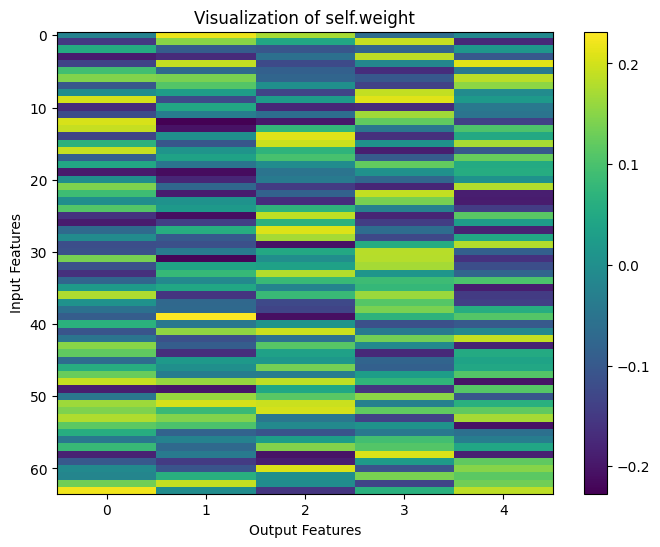

In [2]:
import torch
import matplotlib.pyplot as plt

class NormedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = torch.nn.functional.normalize(x, dim=1).mm(torch.nn.functional.normalize(self.weight, dim=0))
        return out

# Create an instance of the model
model = NormedLinear(in_features=64, out_features=5)

# Get the weight tensor from the model
weight_data = model.weight.data.numpy()

# Plot the figure
plt.figure(figsize=(8, 6))
plt.imshow(weight_data, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Visualization of self.weight')
plt.xlabel('Output Features')
plt.ylabel('Input Features')
plt.show()


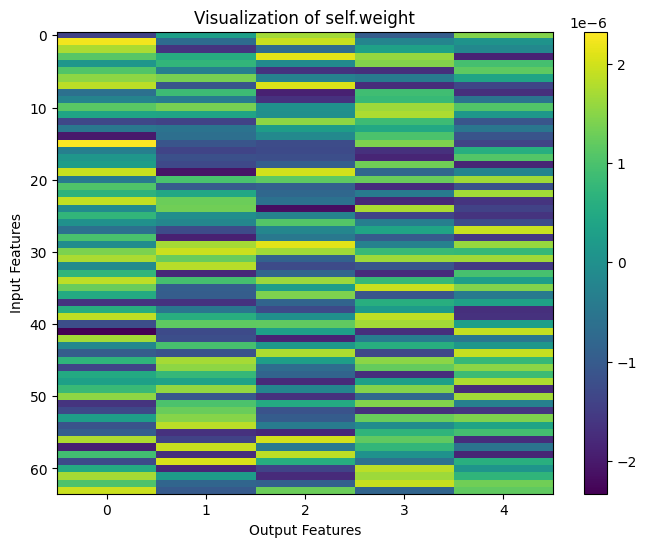

In [3]:
import torch
import matplotlib.pyplot as plt

class NormedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5) #.mul_(1e5)

    def forward(self, x):
        out = torch.nn.functional.normalize(x, dim=1).mm(torch.nn.functional.normalize(self.weight, dim=0))
        return out

# Create an instance of the model
model = NormedLinear(in_features=64, out_features=5)

# Get the weight tensor from the model
weight_data = model.weight.data.numpy()

# Plot the figure
plt.figure(figsize=(8, 6))
plt.imshow(weight_data, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Visualization of self.weight')
plt.xlabel('Output Features')
plt.ylabel('Input Features')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

from fedml_api.model.basic.group_normalization import GroupNorm2d

import random

__all__ = ['ResNet_s', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.planes = planes
                self.in_planes = in_planes
                # self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes // 4, planes // 4), "constant", 0))
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, (planes - in_planes) // 2, (planes - in_planes) // 2), "constant", 0))
                
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module): 

    def __init__(self, block, num_blocks, num_experts, num_classes=10, reduce_dimension=False, layer2_output_dim=None,
                 layer3_output_dim=None, use_norm=False, returns_feat=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes

        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32

        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64

        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1

        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]

        self.s = s

        self.apply(_weights_init)
        # self.moe_pool = nn.AdaptiveAvgPool2d((8, 8))
        # self.moe_nn = nn.Linear(16*8*8, self.num_experts, bias=False)
        # nn.init.constant_(self.moe_nn.weight, 1)
        self.softmax = nn.Softmax(dim=1)

        self.moe = False

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1

        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)

    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        # self.feat_before_GAP.append(out)
        print("out:",out.shape)
        out = F.avg_pool2d(out, out.size()[3])
        print("later out:",out.shape)
        out = out.view(out.size(0), -1)
        # self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out

    def forward(self, x, output_all=False, ano=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
        
        for ind in use_experts:
            # print(f"expert:{ind}; out: {out}")
            ano.append(out)
            o = self._separate_part(out, ind)
            # out_min = torch.min(o)
            # out_max = torch.max(o)
            # o = (o - out_min)/(out_max - out_min)
            # o = o * 2 - 1
            outs.append(o)

        # self.feat = torch.stack(self.feat, dim=1)
        # self.feat_before_GAP = torch.stack(self.feat_before_GAP, dim=1)

        # if self.moe:
        #     moe_weight = self.moe_pool(out)
        #     moe_weight = moe_weight.view(moe_weight.size(0), -1)
        #     moe_weight = self.moe_nn(moe_weight)
        #     moe_weight = self.softmax(moe_weight).unsqueeze(-1)
        #
        #     self.moe_weight = moe_weight
        #     final_out = torch.stack(outs, dim=-1) @ moe_weight
        #     final_out = final_out.squeeze(-1)
        # else:
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_all:
            return final_out, outs
        else:
            return final_out, ano


In [5]:
backbone = ResNet_s(BasicBlock, [5, 5, 5], num_classes=100, reduce_dimension=True, layer2_output_dim=None, layer3_output_dim=None, use_norm=True, num_experts=3)


In [6]:
x = torch.randn(16, 3, 32,32)
hs = []

_, hs = backbone(x,ano=hs)
# print(hs[0]==hs[1])
# print(hs[1]==hs[2])

out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])
out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])
out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])


In [7]:
hs[0].data_ptr()

118366592

In [8]:
hs[1].data_ptr()

118366592

In [9]:
x = hs[0]
x.data_ptr()

118366592

In [10]:
y = torch.randn(2,4)
y

tensor([[ 0.7902, -0.1235, -0.6104,  0.2379],
        [-0.0396,  0.6645,  0.3773, -0.6373]])

In [11]:
y.data_ptr()

118312640

In [12]:
y_ = y
y_ = torch.nn.Linear(4,2)(y_)
y_

tensor([[ 0.0904, -0.8945],
        [ 0.3659,  0.2762]], grad_fn=<AddmmBackward0>)

In [13]:
y_.data_ptr()

95265152

In [14]:
y.data_ptr()

118312640

In [15]:
y = torch.nn.Linear(4,2)(y)
y

tensor([[ 0.7151, -0.1333],
        [-0.2793,  0.4794]], grad_fn=<AddmmBackward0>)

In [16]:
y.data_ptr()

118243072

In [17]:
y = torch.randn(1,3)
y.data_ptr()


94517504

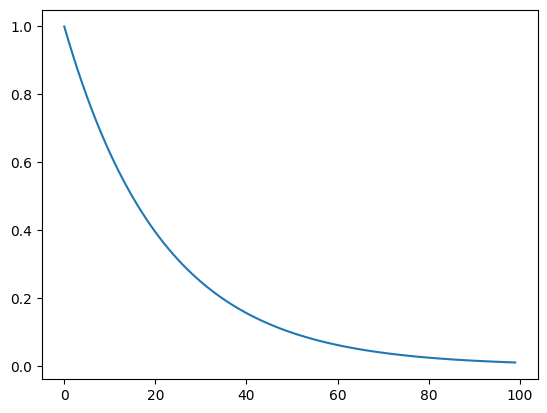

In [23]:
import matplotlib.pyplot as plt
import numpy as np

img_max = 1
imb_factor = 0.01
cls_idx = np.arange(100)
cls_num = 100
num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
plt.plot(cls_idx, num)
plt.show()

In [4]:
def f():
    return {"aa":12}


In [5]:
a = f()
a

{'aa': 12}

In [6]:
a["aa"]

12

In [4]:
import torch
data = torch.randn(2,3,4).cuda()

# 将data拆分为x[0]和x[1]
x,y = torch.chunk(data, chunks=2, dim=0)

# 输出x[0]和x[1]
print(x.cpu().squeeze(0).shape)

torch.Size([3, 4])


In [7]:
x = torch.split(data, split_size_or_sections=2, dim=0)
x

(tensor([[[ 0.5561, -0.4108, -0.6394, -0.2286],
          [ 0.8445, -1.7365,  0.2438,  0.1046],
          [ 0.1571,  0.1412,  0.2121,  1.0972]],
 
         [[-1.2664, -0.6075,  2.2227, -0.6510],
          [ 0.9351,  0.3943, -1.1828,  0.4416],
          [-0.4355,  0.7282,  0.7608,  0.5828]]], device='cuda:0'),)

In [1]:
import torch
import torch.nn as nn

# 定义一个简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建一个实例
model = SimpleNN()

# 获取所有参数并将其堆叠成一个向量
parameters_vector = torch.cat([param.view(-1) for param in model.parameters()])

print(parameters_vector)


print(model.cpu().state_dict())

tensor([-0.2820,  0.1149, -0.1812,  0.2623, -0.2704,  0.0332, -0.0504,  0.2001,
         0.1035,  0.2469,  0.2052, -0.2572, -0.2420,  0.2589, -0.2869,  0.3095,
         0.2378,  0.2223, -0.1513,  0.2731,  0.1027,  0.1664, -0.2486,  0.0172,
         0.0700,  0.2003, -0.2024, -0.2807, -0.0365, -0.2508,  0.0124, -0.1988,
        -0.2593, -0.2692, -0.1203, -0.2666, -0.2237,  0.2377,  0.0899,  0.0621,
        -0.0883, -0.0989,  0.2661, -0.1200, -0.2924,  0.1591, -0.3076, -0.0314,
        -0.3027,  0.2095, -0.2556, -0.0836,  0.2151,  0.2327,  0.2688,  0.3594,
         0.2095,  0.3339, -0.2000, -0.2837, -0.4321], grad_fn=<CatBackward0>)
OrderedDict([('fc1.weight', tensor([[-0.2820,  0.1149, -0.1812,  0.2623, -0.2704,  0.0332, -0.0504,  0.2001,
          0.1035,  0.2469],
        [ 0.2052, -0.2572, -0.2420,  0.2589, -0.2869,  0.3095,  0.2378,  0.2223,
         -0.1513,  0.2731],
        [ 0.1027,  0.1664, -0.2486,  0.0172,  0.0700,  0.2003, -0.2024, -0.2807,
         -0.0365, -0.2508],
       

In [3]:
[p for p in model.cpu().parameters()]

[Parameter containing:
 tensor([[-0.2820,  0.1149, -0.1812,  0.2623, -0.2704,  0.0332, -0.0504,  0.2001,
           0.1035,  0.2469],
         [ 0.2052, -0.2572, -0.2420,  0.2589, -0.2869,  0.3095,  0.2378,  0.2223,
          -0.1513,  0.2731],
         [ 0.1027,  0.1664, -0.2486,  0.0172,  0.0700,  0.2003, -0.2024, -0.2807,
          -0.0365, -0.2508],
         [ 0.0124, -0.1988, -0.2593, -0.2692, -0.1203, -0.2666, -0.2237,  0.2377,
           0.0899,  0.0621],
         [-0.0883, -0.0989,  0.2661, -0.1200, -0.2924,  0.1591, -0.3076, -0.0314,
          -0.3027,  0.2095]], requires_grad=True),
 Parameter containing:
 tensor([-0.2556, -0.0836,  0.2151,  0.2327,  0.2688], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3594,  0.2095,  0.3339, -0.2000, -0.2837]], requires_grad=True),
 Parameter containing:
 tensor([-0.4321], requires_grad=True)]

In [6]:
torch.cat([e.view(-1) for e in model.cpu().state_dict().values()])

tensor([-0.2820,  0.1149, -0.1812,  0.2623, -0.2704,  0.0332, -0.0504,  0.2001,
         0.1035,  0.2469,  0.2052, -0.2572, -0.2420,  0.2589, -0.2869,  0.3095,
         0.2378,  0.2223, -0.1513,  0.2731,  0.1027,  0.1664, -0.2486,  0.0172,
         0.0700,  0.2003, -0.2024, -0.2807, -0.0365, -0.2508,  0.0124, -0.1988,
        -0.2593, -0.2692, -0.1203, -0.2666, -0.2237,  0.2377,  0.0899,  0.0621,
        -0.0883, -0.0989,  0.2661, -0.1200, -0.2924,  0.1591, -0.3076, -0.0314,
        -0.3027,  0.2095, -0.2556, -0.0836,  0.2151,  0.2327,  0.2688,  0.3594,
         0.2095,  0.3339, -0.2000, -0.2837, -0.4321])

In [7]:
def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v - sum(torch.dot(v, b) / torch.dot(b, b) * b for b in basis)
        basis.append(w)
    return torch.stack(basis)

# 生成两个向量
v1 = torch.tensor([1.0, 2.0, 3.0])
v2 = torch.tensor([4.0, 5.0, 6.0])

# 正交化
orthogonal_basis = gram_schmidt([v1, v2])

# 得到正交化后的向量
v1_orthogonal = orthogonal_basis[0]
v2_orthogonal = orthogonal_basis[1]

print("正交化后的v1:", v1_orthogonal)
print("正交化后的v2:", v2_orthogonal)


正交化后的v1: tensor([1., 2., 3.])
正交化后的v2: tensor([ 1.7143,  0.4286, -0.8571])


In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
g = torch.load("fedml_experiments/clsimb_fedavg/g.pth")
l = torch.load("fedml_experiments/clsimb_fedavg/l.pth")
g_cat = torch.cat([g[k].view(-1) for k in g.keys() if "num_batches_tracked" not in k]).cpu()
l_cat = torch.cat([l[k].view(-1) for k in l.keys() if "num_batches_tracked" not in k]).cpu()

AttributeError: 'list' object has no attribute 'keys'

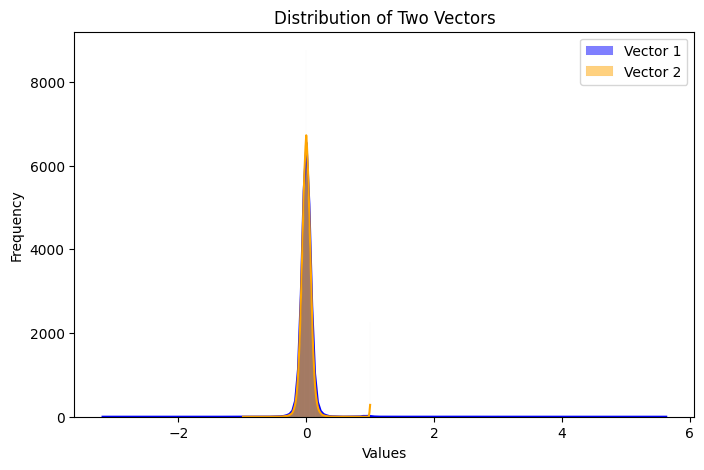

In [19]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(l_cat, kde=True, color='blue', label='Vector 1')
sns.histplot(g_cat, kde=True, color='orange', label='Vector 2')

plt.title('Distribution of Two Vectors')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

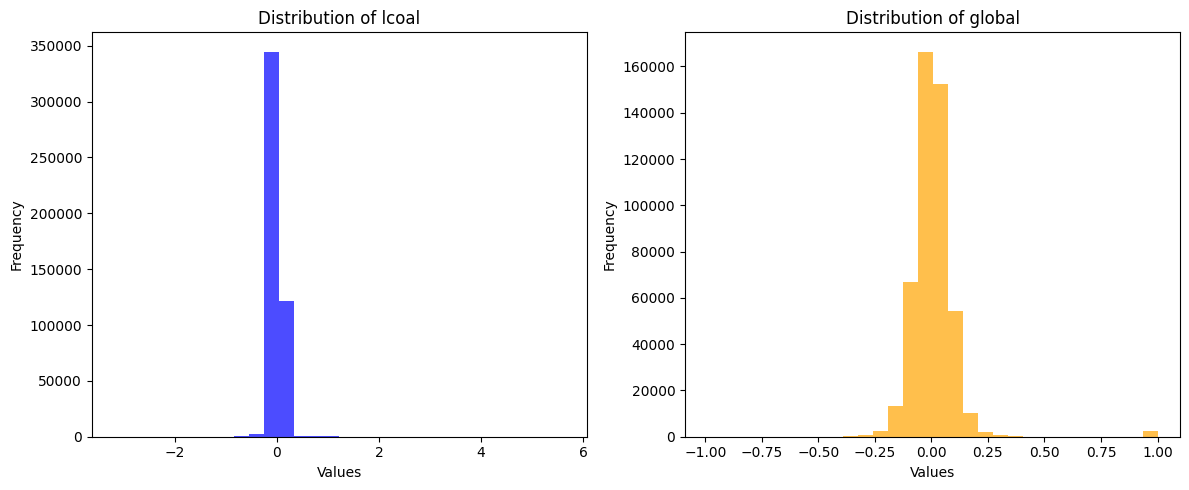

In [20]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Vector 1
ax1.hist(l_cat, bins=30, color='blue', alpha=0.7)
ax1.set_title('Distribution of lcoal')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for Vector 2
ax2.hist(g_cat, bins=30, color='orange', alpha=0.7)
ax2.set_title('Distribution of global')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

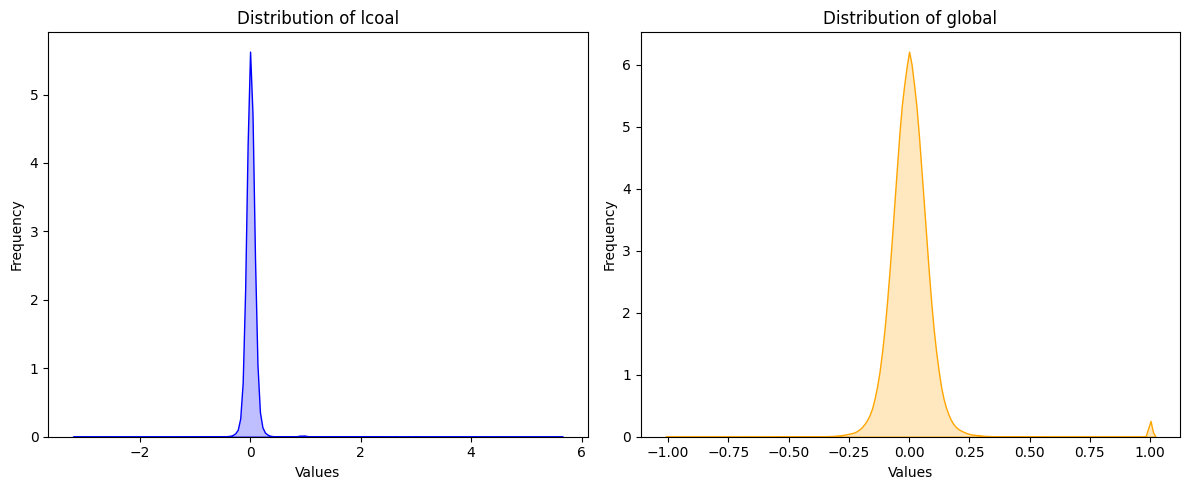

In [22]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Vector 1
# ax1.hist(l_cat, bins=30, color='blue', alpha=0.7)
sns.kdeplot(l_cat, ax=ax1, label='local', color='blue', fill=True)
ax1.set_title('Distribution of lcoal')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for Vector 2
# ax2.hist(g_cat, bins=30, color='orange', alpha=0.7)
sns.kdeplot(g_cat, ax=ax2, label='global', color='orange', fill=True)
ax2.set_title('Distribution of global')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
def kde_model(path, label, func=None):
    if func is None:
        model_state_dict = torch.load(path)
    else: 
        model_state_dict = func(path)
    # model_state_dict = np.array()
    param_cat_vec = torch.cat([model_state_dict[k].view(-1) for k in model_state_dict.keys() if "bn" not in k]).cpu()
    # plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(param_cat_vec, label=label, color='blue', fill=True)

    plt.title(f'Kernel Density Estimate of {label}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()  

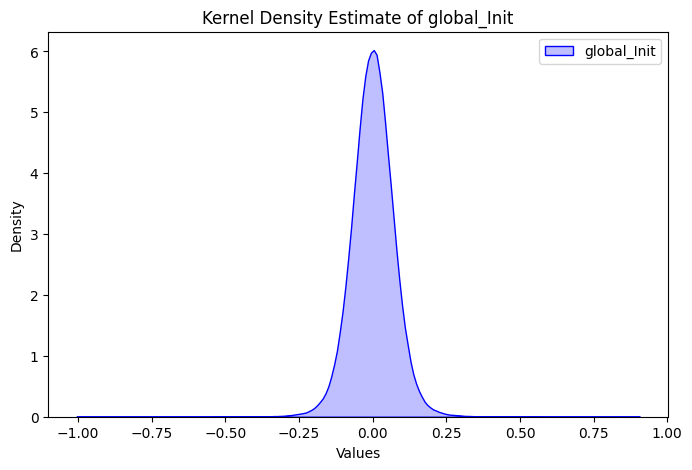

In [9]:
kde_model("fedml_experiments/clsimb_fedavg/g.pth", "global_Init")

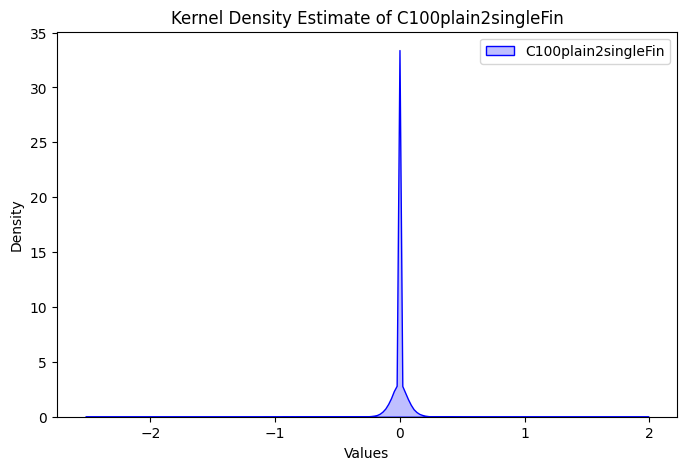

In [10]:
def load_check(path):
    checkpoint = torch.load(path)
    return checkpoint['model']

kde_model("/root/Federated-Long-tailed-Learning/checkpoint/C100_plain_2SingleFIN/round_80000_global.pth", "C100plain2singleFin", func=load_check)

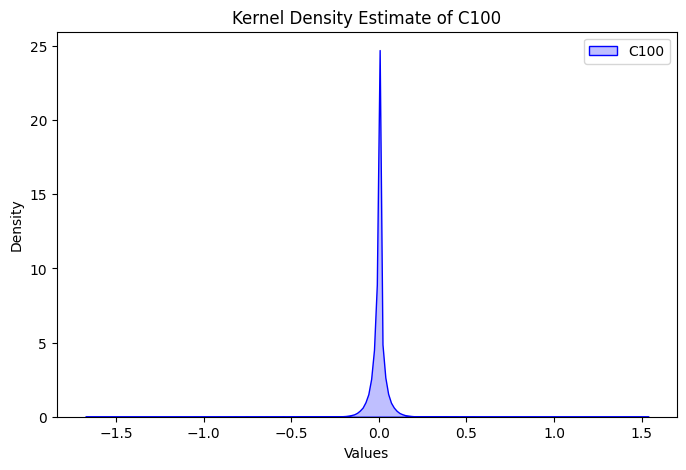

In [11]:
def load_check(path):
    checkpoint = torch.load(path)
    return checkpoint['model']

kde_model("/root/Federated-Long-tailed-Learning/checkpoint/C100/round_2500_global.pth", "C100", func=load_check)

In [13]:
model_state_dict = load_check("/root/Federated-Long-tailed-Learning/checkpoint/C100/round_2500_global.pth")
param_cat_vec = torch.cat([model_state_dict[k].view(-1) for k in model_state_dict.keys()]).cpu()
param_cat_vec

tensor([-0.1914, -0.2683, -0.2386,  ..., -0.0037, -0.0255, -0.0194])

In [14]:
param_cat_vec.argmax()

tensor(496)

In [15]:
for idx,k in enumerate(model_state_dict.keys()):
    print(idx, k, f"min: {model_state_dict[k].min().cpu()}", f"max: {model_state_dict[k].max().cpu()}")

0 backbone.conv1.weight min: -1.0152263641357422 max: 1.5311769247055054
1 backbone.bn1.weight min: 4.0340371924685314e-05 max: 1.8034396171569824
2 backbone.bn1.bias min: -0.5155225396156311 max: 1.6232551336288452
3 backbone.bn1.running_mean min: -1.0846004486083984 max: 1.190495491027832
4 backbone.bn1.running_var min: 2.217574319729465e-06 max: 24.480464935302734
5 backbone.bn1.num_batches_tracked min: 10778 max: 10778
6 backbone.layer1.0.conv1.weight min: -0.5741850137710571 max: 0.5974284410476685
7 backbone.layer1.0.bn1.weight min: 0.18342918157577515 max: 0.6198747754096985
8 backbone.layer1.0.bn1.bias min: -0.44939786195755005 max: 0.5775245428085327
9 backbone.layer1.0.bn1.running_mean min: -3.8172757625579834 max: 2.721400499343872
10 backbone.layer1.0.bn1.running_var min: 0.30716651678085327 max: 8.495078086853027
11 backbone.layer1.0.bn1.num_batches_tracked min: 10778 max: 10778
12 backbone.layer1.0.conv2.weight min: -0.5212969183921814 max: 0.47211119532585144
13 backbone